In [1]:
import sys
sys.version

'3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]'

# Chapter 9 - Hierarchical Models

In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
color = '#87ceeb'

from IPython.display import Image
from matplotlib import gridspec

import torch
import torch as th
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

In [3]:
%load_ext watermark
%watermark -p pyro,arviz,scipy,numpy,pandas

pyro  : 1.6.0
arviz : 0.11.2
scipy : 1.6.1
numpy : 1.20.1
pandas: 1.2.3



In [59]:
a = torch.tensor([[1,2], [2,3], [3,4]])
a.shape, a.size(), a.dim()

(torch.Size([3, 2]), torch.Size([3, 2]), 2)

In [66]:
# convenience function
def gomcmc(model, data, num_samples=4000):
    """
    data: dict() type for model function
    """
    mcmc = MCMC(NUTS(model), num_warmup=1500, num_samples=num_samples, num_chains=_ntrace)
    mcmc.run(**data)
    return mcmc

def tensor2numpy(tensor_dict):
    # tensor_dict
    np_dict = {}
    for k, v in tensor_dict.items():
        if v.dim() == 2:
            for i in range(v.shape[1]):
                np_dict[k+f'_{i}'] = v[:,i].numpy()
        elif v.dim() == 1:
            np_dict[k] = v
    return np_dict

## 9.5. Extending the Hierarchy: Subjects within categories

### 9.5.1 - Example: Baseball batting abilities by position

In [6]:
df2 = pd.read_csv('data/BattingAverage.csv', 
                  usecols=[0,1,2,3], 
                  dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


In [7]:
df2

,Player,PriPos,Hits,AtBats
0,Fernando Abad,Pitcher,1,7
1,Bobby Abreu,Left Field,53,219
2,Tony Abreu,2nd Base,18,70
3,Dustin Ackley,2nd Base,137,607
4,Matt Adams,1st Base,21,86
...,...,...,...,...
943,Brad Ziegler,Pitcher,1,4
944,Ryan Zimmerman,3rd Base,163,578
945,Jordan Zimmermann,Pitcher,11,57
946,Barry Zito,Pitcher,4,53


In [8]:
df2.PriPos.unique()

['Pitcher', 'Left Field', '2nd Base', '1st Base', '3rd Base', 'Catcher', 'Shortstop', 'Center Field', 'Right Field']
Categories (9, object): ['Pitcher', 'Left Field', '2nd Base', '1st Base', ..., 'Catcher', 'Shortstop', 'Center Field', 'Right Field']

The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [9]:
# Hit rate by primary field positions
perPosition = df2.groupby('PriPos')[['Hits', 'AtBats']]
pphit = perPosition.sum()
pphit['hit_rate'] = pphit['Hits'] / pphit['AtBats']
pphit

,Hits,AtBats,hit_rate
PriPos,,,
1st Base,5900,22793,0.258851
2nd Base,5068,19822,0.255676
3rd Base,5460,20601,0.265036
Catcher,4766,19264,0.247404
Center Field,4963,18834,0.263513
Left Field,5723,22090,0.259077
Pitcher,650,5033,0.129148
Right Field,4992,18941,0.263555
Shortstop,4478,17548,0.255186


In [10]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')[['Hits','AtBats']].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

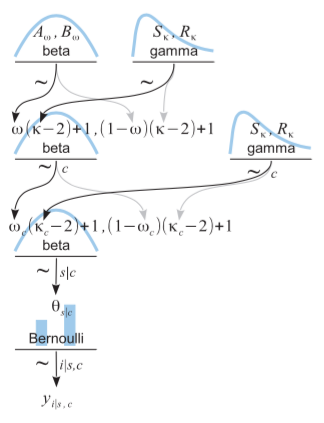

In [12]:
Image('images/fig9_13.png', width=400)

### Data

In [13]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

In [14]:
n_pripos, n_players, len(pripos_idx), len(pripos_codes)

(9, 948, 948, 9)

In [15]:
np.unique(pripos_idx)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int8)

## Pyro Model
- The book uses Gamma(0.01, 0.01) to get a flat distribution for $kappa-1$, but its samples generated does not seem flat over a reasonable range. Other parameters or even other distributions like Exp should be considered.

### Modeling

In [22]:
def model(n_pripos, n_players, pripos_idx, atBats, Hits=None):
    """
    pripos_idx, atBats, Hits: jnp DeviceArray
    """
    omega = pyro.sample('omega', dist.Beta(1,1))  # 
    kappa_minus2 = pyro.sample('kappa_minus2', dist.Gamma(0.01, 0.01))
    kappa = kappa_minus2 + 2
    pyro.deterministic('kappa', kappa)  # just to make record
    
    # categoris: Primary field positions
    with pyro.plate('omega_c_plate', size=n_pripos):  # equivalent to running a for loop
        omega_c = pyro.sample('omega_c', dist.Beta(omega*(kappa-2)+1, (1-omega)*(kappa-2)+1))
        kappa_c_minus2 = pyro.sample('kappa_c_minus2', dist.Gamma(0.01, 0.01))
#     print('# num of primary positions: ', omega_c.shape)  # should be 9
    
    kappa_c = kappa_c_minus2 + 2
    pyro.deterministic('kappa_c', kappa_c)
    
    alpha = omega_c[pripos_idx] * (kappa_c[pripos_idx] - 2) + 1
    beta  = (1-omega_c[pripos_idx]) * (kappa_c[pripos_idx] - 2) + 1
    
#     with numpyro.plate('theta_sample', size=n_players):
    theta = pyro.sample('theta', dist.Beta(alpha, beta))
        
#     with numpyro.plate('observation', size=n_players):
    pyro.sample('obs', dist.Binomial(total_count=atBats, probs=theta), obs=Hits)

### Prior Predictive Check

In [31]:
prior_check = Predictive(model, num_samples=2021)(n_pripos, n_players, th.tensor(pripos_idx, dtype=th.long), th.tensor(df2.AtBats.values))
prior_check = {k: np.array(v) for k, v in prior_check.items()}

In [32]:
prior_check.keys()

dict_keys(['omega', 'kappa_minus2', 'omega_c', 'kappa_c_minus2', 'theta', 'obs', 'kappa', 'kappa_c'])

In [33]:
prior_check['obs'].shape

(2021, 948)

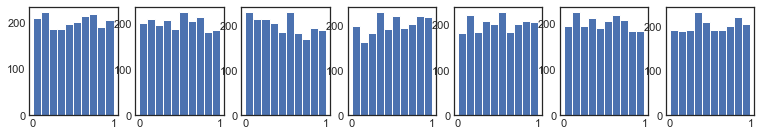

In [34]:
fig, axes = plt.subplots(1, 7, figsize=(13,2))
for i, ax in enumerate(axes.ravel()):
    ax.hist(prior_check['theta'][:,i])  # distriubtion of theta_i should be almost flat since we have no observation enforced yet.

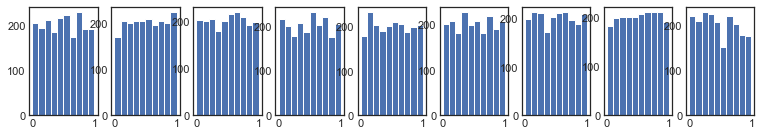

In [35]:
fig, axes = plt.subplots(1, 9, figsize=(13,2))
for i, ax in enumerate(axes.ravel()):
    ax.hist(prior_check['omega_c'][:, i])  # flat for the same reason

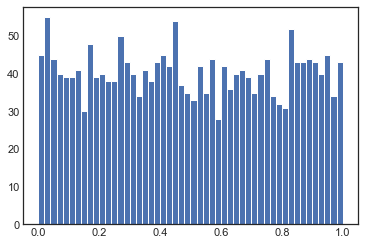

In [36]:
plt.hist(prior_check['omega'], bins=50);

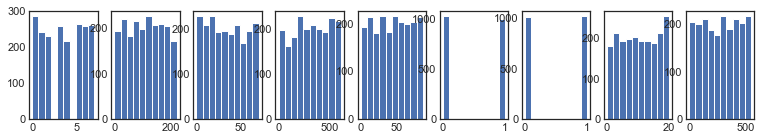

In [37]:
fig, axes = plt.subplots(1, 9, figsize=(13,2))
for i, ax in enumerate(axes.ravel()):
    ax.hist(prior_check['obs'][:, i])  # flat for the same reason

### Prepare Data for Inference with numpyro

In [38]:
npr_data = dict(n_pripos = n_pripos, 
                n_players = n_players,
                pripos_idx = torch.LongTensor(pripos_idx),
                atBats = torch.tensor(df2.AtBats.values),
                Hits = torch.tensor(df2.Hits.values)
               )

### Run MCMC

In [41]:
%%time
mcmc = MCMC(NUTS(model), warmup_steps=500, num_samples=2000)  # progress bar not yet implemented in numpyro for multiple traces
mcmc.run(**npr_data)

Sample: 100%|███████████████████████████████████████| 2500/2500 [05:26,  7.66it/s, step size=2.04e-01, acc. prob=0.854]

Wall time: 5min 26s


In [42]:
mcmc.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            omega      0.23      0.02      0.23      0.19      0.26   1399.24      1.00
     kappa_minus2     59.47     33.19     53.84      9.83    104.75   1618.62      1.00
       omega_c[0]      0.25      0.00      0.25      0.24      0.26   1095.48      1.00
       omega_c[1]      0.25      0.01      0.25      0.24      0.26   1221.65      1.00
       omega_c[2]      0.26      0.01      0.26      0.25      0.26   1173.43      1.00
       omega_c[3]      0.24      0.01      0.24      0.23      0.24   1145.97      1.00
       omega_c[4]      0.26      0.01      0.26      0.25      0.27   1337.79      1.00
       omega_c[5]      0.25      0.00      0.25      0.24      0.26   1004.48      1.00
       omega_c[6]      0.12      0.01      0.12      0.11      0.13    147.77      1.00
       omega_c[7]      0.26      0.00      0.26      0.25      0.27    921.70      1.00
       omega_c[8]      0.25    

In [67]:
mcmcsamples = mcmc.get_samples()
print(mcmcsamples['omega_c'].shape)
mcmcsamples = tensor2numpy(mcmcsamples)
mcmcsamples

torch.Size([2000, 9])


{'omega': tensor([0.2254, 0.2333, 0.2339,  ..., 0.2764, 0.2210, 0.2498]),
 'kappa_minus2': tensor([71.9824, 58.0604, 55.9191,  ..., 39.8233, 82.5945, 79.8169]),
 'omega_c_0': array([0.2527595 , 0.25634125, 0.25523296, ..., 0.26288742, 0.25910044,
        0.25864822], dtype=float32),
 'omega_c_1': array([0.24805714, 0.24483705, 0.24232979, ..., 0.24600376, 0.25390303,
        0.24426132], dtype=float32),
 'omega_c_2': array([0.25143886, 0.24757092, 0.24687375, ..., 0.2656534 , 0.2593571 ,
        0.262496  ], dtype=float32),
 'omega_c_3': array([0.2436804 , 0.2296576 , 0.22857496, ..., 0.24544187, 0.24492961,
        0.24846871], dtype=float32),
 'omega_c_4': array([0.26203352, 0.25133723, 0.25070393, ..., 0.25780794, 0.25311628,
        0.2568017 ], dtype=float32),
 'omega_c_5': array([0.25489017, 0.25261644, 0.25014016, ..., 0.24005198, 0.24201146,
        0.24411035], dtype=float32),
 'omega_c_6': array([0.12253965, 0.12240415, 0.12284342, ..., 0.13123089, 0.13210146,
        0.12929

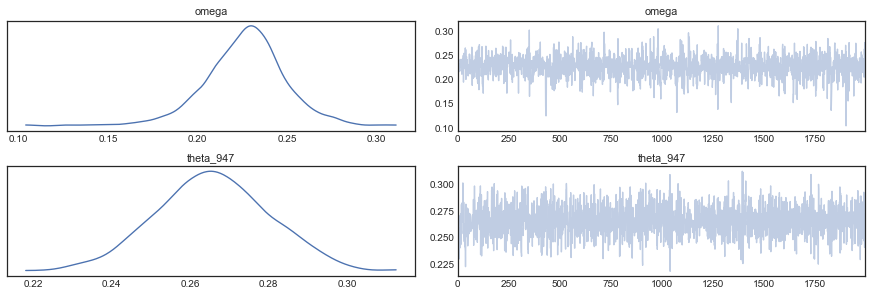

In [69]:
az.plot_trace(mcmcsamples, ['omega', 'theta_947']);

### Trace Plots

In [85]:
trace = az.from_dict(mcmcsamples).posterior
trace

<xarray.Dataset>
Dimensions:           (chain: 1, draw: 2000)
Coordinates:
  * chain             (chain) int32 0
  * draw              (draw) int32 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Data variables: (12/968)
    omega             (chain, draw) float32 0.2254 0.2333 ... 0.221 0.2498
    kappa_minus2      (chain, draw) float32 71.98 58.06 55.92 ... 82.59 79.82
    omega_c_0         (chain, draw) float32 0.2528 0.2563 ... 0.2591 0.2586
    omega_c_1         (chain, draw) float32 0.2481 0.2448 ... 0.2539 0.2443
    omega_c_2         (chain, draw) float32 0.2514 0.2476 ... 0.2594 0.2625
    omega_c_3         (chain, draw) float32 0.2437 0.2297 ... 0.2449 0.2485
    ...                ...
    theta_942         (chain, draw) float32 0.1175 0.1491 ... 0.1561 0.1182
    theta_943         (chain, draw) float32 0.134 0.1261 0.1285 ... 0.173 0.1578
    theta_944         (chain, draw) float32 0.2819 0.2496 ... 0.2673 0.2783
    theta_945         (chain, draw) float32 0.123 0.1581 0.167 ... 0.1267 0.1559
    theta_946         (chain, draw) float32 0.1199 0.112 ... 0.1497 0.1049
    theta_947         (chain, draw) float32 0.2516 0.2595 ... 0.2725 0.2602
Attributes:
    created_at:     2021-03-15T03:21:03.015638
    arviz_version:  0.11.2

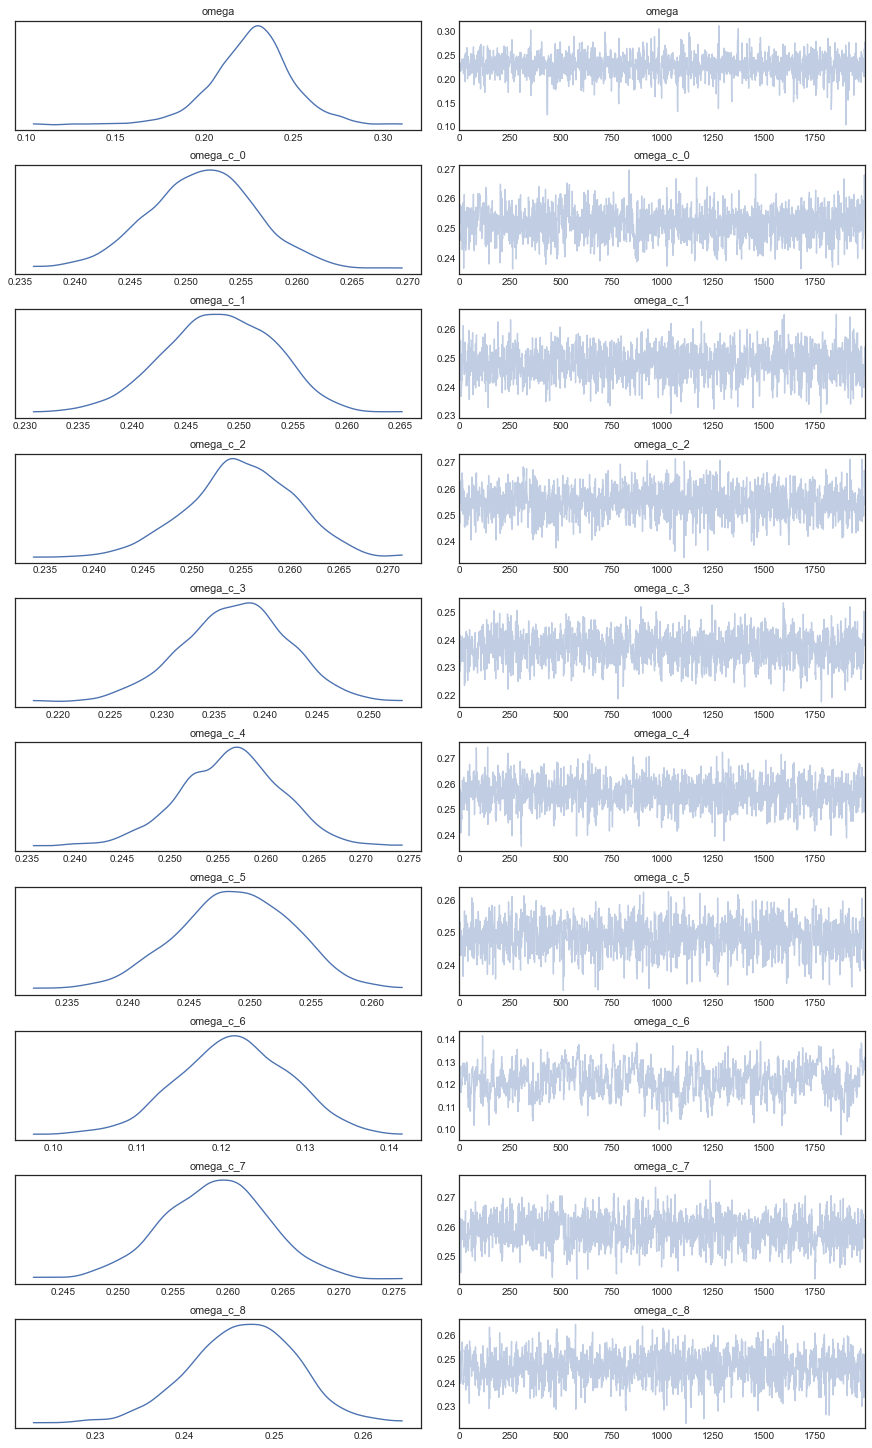

In [82]:
az.plot_trace(trace, ['omega'] +[f'omega_c_{i}' for i in range(9)]);

### Posterior Plots

In [88]:
inferenceData = az.from_pyro(mcmc)
trace = inferenceData.posterior
trace

<xarray.Dataset>
Dimensions:               (chain: 1, draw: 2000, kappa_c_minus2_dim_0: 9, omega_c_dim_0: 9, theta_dim_0: 948)
Coordinates:
  * chain                 (chain) int32 0
  * draw                  (draw) int32 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * omega_c_dim_0         (omega_c_dim_0) int32 0 1 2 3 4 5 6 7 8
  * kappa_c_minus2_dim_0  (kappa_c_minus2_dim_0) int32 0 1 2 3 4 5 6 7 8
  * theta_dim_0           (theta_dim_0) int32 0 1 2 3 4 ... 943 944 945 946 947
Data variables:
    omega                 (chain, draw) float32 0.2254 0.2333 ... 0.221 0.2498
    kappa_minus2          (chain, draw) float32 71.98 58.06 ... 82.59 79.82
    omega_c               (chain, draw, omega_c_dim_0) float32 0.2528 ... 0.2466
    kappa_c_minus2        (chain, draw, kappa_c_minus2_dim_0) float32 276.2 ....
    theta                 (chain, draw, theta_dim_0) float32 0.1269 ... 0.2602
Attributes:
    created_at:                 2021-03-15T03:21:58.114445
    arviz_version:              0.11.2
    inference_library:          pyro
    inference_library_version:  1.6.0

#### Figure 9.14 Marginal posterior for Pitcher and Catcher

In [89]:
pitcher_id = list(pripos_codes).index('Pitcher')
catcher_id = list(pripos_codes).index('Catcher')
pitcher = np.array(trace.omega_c[:,:, pitcher_id]).reshape(-1)
catcher = np.array(trace.omega_c[:,:, catcher_id]).reshape(-1)
pmc = pitcher - catcher # posterior samples of the difference
pmc.shape

(2000,)

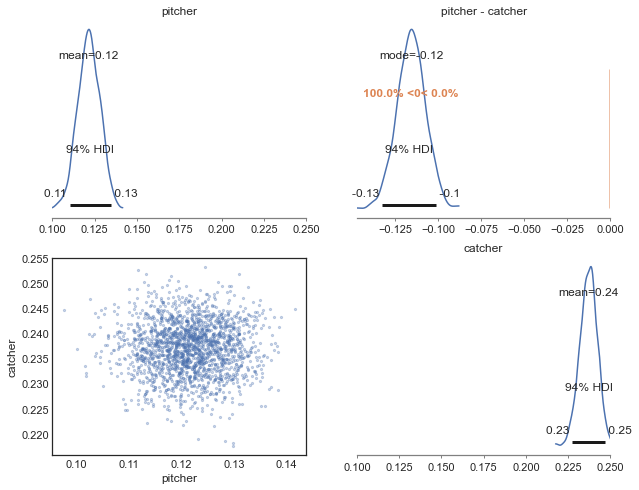

In [90]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
ax0, ax1, ax2, ax3 = axes.ravel()
az.plot_posterior(pitcher, ax=ax0)
ax0.set_xlim(0.1, 0.25); ax0.set_title('pitcher')
az.plot_posterior(pmc, point_estimate='mode', ref_val=0., ax=ax1); ax1.set_xlim(pmc.min(), 0); ax1.set_title('pitcher - catcher');
ax2.scatter(pitcher, catcher, marker='o', s=5, alpha=.3)
ax2.set_xlabel('pitcher'); ax2.set_ylabel('catcher')
az.plot_posterior(catcher, ax=ax3)
ax3.set_xlim(0.1, 0.25); ax3.set_title('catcher');

In [95]:
def plot_difference(omega_c, namelist, title=None):
    pitcher_id = list(pripos_codes).index(namelist[0])
    catcher_id = list(pripos_codes).index(namelist[1])

    pitcher = np.array(omega_c[:,:, pitcher_id]).reshape(-1)
    catcher = np.array(omega_c[:,:, catcher_id]).reshape(-1)
    pmc = pitcher - catcher # posterior samples of the difference

    fig, axes = plt.subplots(2,2, figsize=(10,8))
    ax0, ax1, ax2, ax3 = axes.ravel()
    
    az.plot_posterior(pitcher, point_estimate='mean',ax=ax0); ax0.set_title(namelist[0])
    
    az.plot_posterior(pmc, point_estimate='mean', ref_val=0., ax=ax1); ax1.set_title(f'{namelist[0]} - {namelist[1]}');
    
    ax2.scatter(pitcher, catcher, marker='o', s=15, alpha=.3); ax2.set_xlabel(namelist[0]); ax2.set_ylabel(namelist[1])
    ax2.plot([0,1], [0,1], '--')
    ax2.set_xlim(pitcher.min()*.99, pitcher.max()*1.01)
    ax2.set_ylim(catcher.min()*.99, catcher.max()*1.01)
    
    az.plot_posterior(catcher, point_estimate='mean',ax=ax3); ax3.set_title(namelist[1]);
    
    for ax in [ax0, ax3]:
        ax.set_xlim(min([pitcher.min(), catcher.min()]),  max([pitcher.max(), catcher.max()]))
    
    if title is not None:
        fig.suptitle(title)

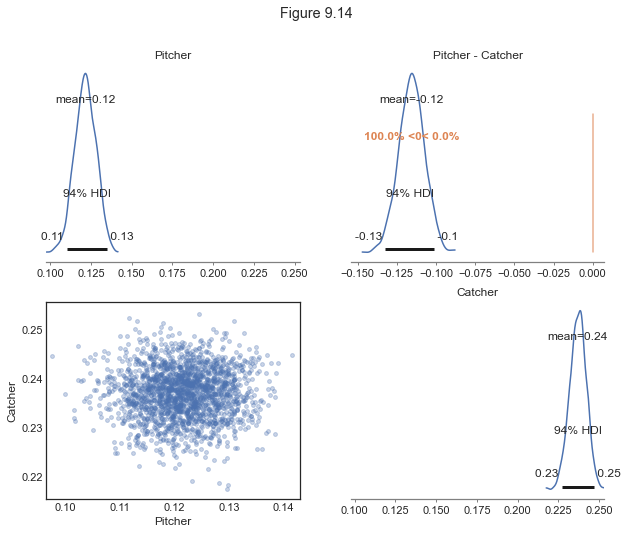

In [96]:
plot_difference(trace.omega_c, ['Pitcher', 'Catcher'],
               title='Figure 9.14')

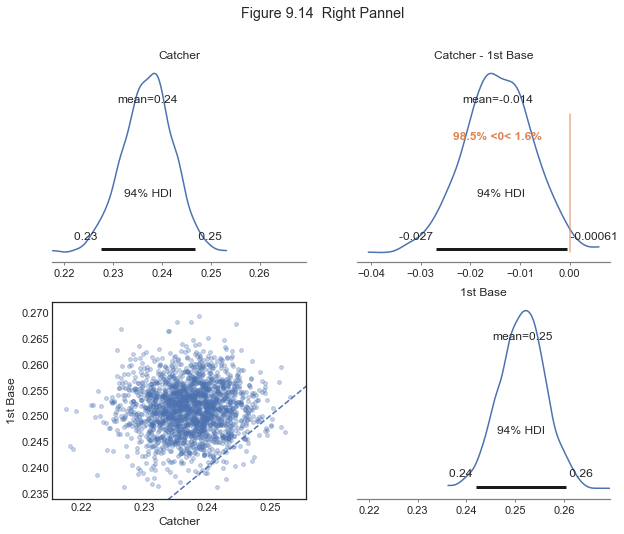

In [97]:
plot_difference(trace.omega_c, ['Catcher', '1st Base'],
               title='Figure 9.14  Right Pannel')

Plot for players

#### **Figure 9.17** Posterior distributions of the omega_c parameters after sampling.

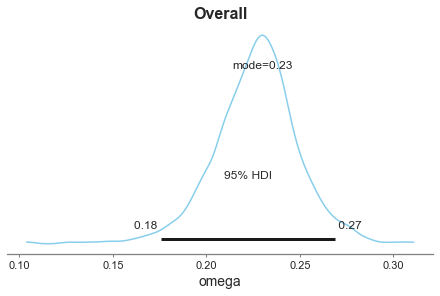

In [100]:
az.plot_posterior(trace, var_names=['omega'], point_estimate='mode', hdi_prob=.95, color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

**Figure 9.17** Posterior distributions of the omega_c parameters after sampling.

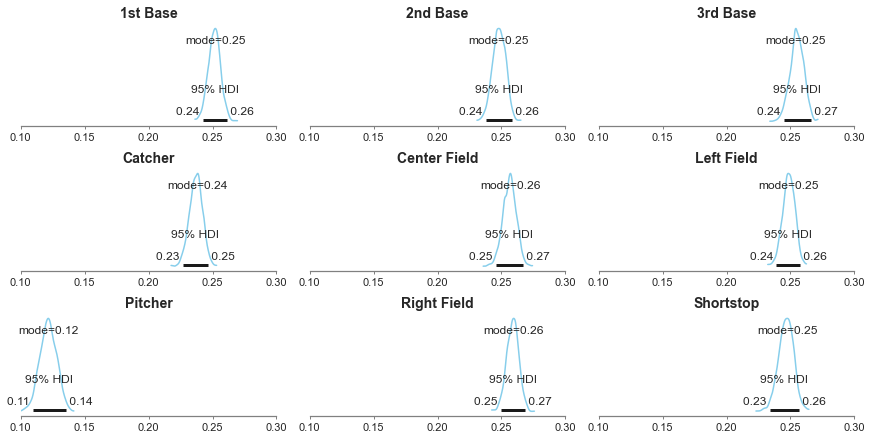

In [101]:
# fig, axes = plt.subplots(3, 3, figsize=(15,5))
axes = az.plot_posterior(trace, var_names=['omega_c'], point_estimate='mode', hdi_prob=.95, color=color, figsize=(12,6));
for ax, pname in zip(axes.ravel(), pripos_codes):
    ax.set_title(pname, fontdict={'fontsize':14, 'fontweight':'bold'})
    ax.set_xlim(0.10,0.30)

End.

---

## Gamma Distribution
https://en.wikipedia.org/wiki/Gamma_distribution
- Its domain (or support): $x \in (0, \infty)$
- Three ways of parametrization of Gamma distribution
    1. shape, scale: $(\kappa, \theta)$
    2. shape, rate: $(\alpha, \beta)$, where $\alpha=\kappa$ and $\beta = 1/\theta$
    3. shape, mean: $(\kappa, \mu)$, where $\mu = \kappa\theta = \alpha / \beta$
- The mode is at
    - $(\kappa - 1)\theta$ for $\kappa \geq 1$   (ss parameterization)
    - $\frac{\alpha - 1}{\beta}$ for $\alpha \geq 1$ (sr parameterization)
- Variance:
    - V = $\kappa \theta^2$ = $\frac{\alpha}{\beta^2}$

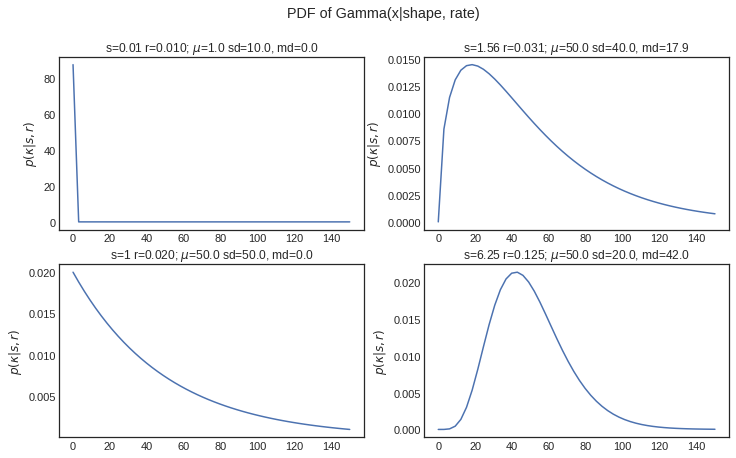

In [33]:
x=np.linspace(0.0001,150)
fig, axes = plt.subplots(2,2, figsize=(12,7))
shape_rates = [ [0.01, 0.01], [1.56, 0.0312], [1, 0.02], [6.25, 0.125] ]  # shape, rate == (alpha, beta)
for ax, (shape, rate) in zip(axes.ravel(), shape_rates):
    gammapdf = stats.gamma(a=shape, scale=1./rate).pdf(x)
    ax.plot(x, gammapdf)
    mu = shape / rate
    sd = np.sqrt(mu / rate)
    mode = (shape - 1) / rate if shape >= 1 else 0
    ax.set_title(f's={shape} r={rate:.3f}; $\mu$={mu:.1f} sd={sd:.1f}, md={mode:.1f}')
    ax.set_ylabel('$p(\kappa|s, r)$')
fig.suptitle('PDF of Gamma(x|shape, rate)');

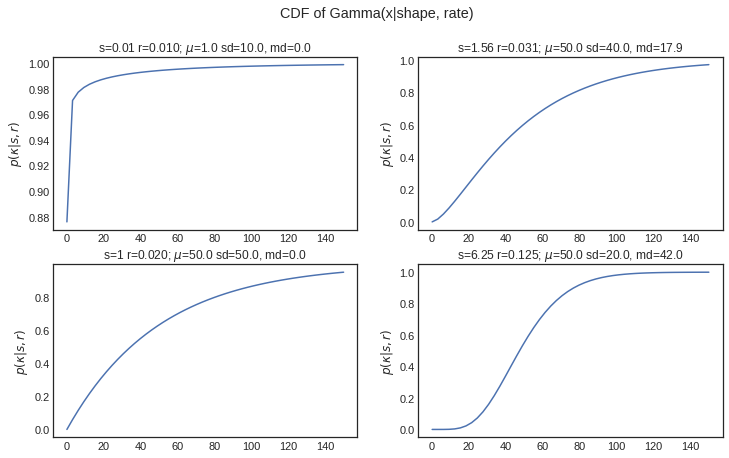

In [34]:
x=np.linspace(0.0001,150)
fig, axes = plt.subplots(2,2, figsize=(12,7))
shape_rates = [ [0.01, 0.01], [1.56, 0.0312], [1, 0.02], [6.25, 0.125] ]  # shape, rate == (alpha, beta)
for ax, (shape, rate) in zip(axes.ravel(), shape_rates):
    gammapdf = stats.gamma(a=shape, scale=1./rate).cdf(x)
    ax.plot(x, gammapdf)
    mu = shape / rate
    sd = np.sqrt(mu / rate)
    mode = (shape - 1) / rate if shape >= 1 else 0
    ax.set_title(f's={shape} r={rate:.3f}; $\mu$={mu:.1f} sd={sd:.1f}, md={mode:.1f}')
    ax.set_ylabel('$p(\kappa|s, r)$')
fig.suptitle('CDF of Gamma(x|shape, rate)');

End.